<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Clusterize-the-database-sequences" data-toc-modified-id="Clusterize-the-database-sequences-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Clusterize the database sequences</a></span></li><li><span><a href="#Read" data-toc-modified-id="Read-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Read</a></span><ul class="toc-item"><li><span><a href="#download-results" data-toc-modified-id="download-results-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>download results</a></span></li></ul></li><li><span><a href="#Get-clusterized-sequences-and-taxa" data-toc-modified-id="Get-clusterized-sequences-and-taxa-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Get clusterized sequences and taxa</a></span></li></ul></div>

In [15]:
from qiime2 import Artifact

from os.path import join, dirname, exists, basename, splitext
import os
from glob import glob

import networkx as nx
import matplotlib.pyplot as plt

import pickle
import multiprocessing as mp

from Bio import SeqIO
from Bio.SeqRecord import SeqRecord

import utils
import new_approach
import parse_cdhit

%matplotlib inline
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
db_dir = 'created_db'
db_name = 'gsrv'
v_regions = ["V4", "V3-V4", "V1-V3", "V3-V5"]
identities = [0.99, 1]

In [17]:
# Outputs
env_files = {}
cdhit_out = {}
cdhit_out_ord = {}
db_out_prefix = {}


for v_region in v_regions:
    # database files
    env_files[v_region] = {
        'seq' : glob(
            join(db_dir, f"{db_name}_{v_region}*.fasta"))[0],
        'taxa': glob(
            join(db_dir, f"{db_name}_{v_region}*.txt"))[0]
    }
    
    # Outdir
    cluster_dir = f"Clustering/{v_region}"
    utils.check_dir(cluster_dir)
    
    # chdit out
    cdhit_out[v_region] = { identity: join(
        cluster_dir, 
        f"{db_name}_{v_region}_cluster-{identity}.clstr"
    ) for identity in identities}
    
    cdhit_out_ord[v_region] = { identity: join(
        cluster_dir, 
        f"{db_name}_{v_region}_cluster-{identity}_ord.clstr"
    ) for identity in identities}
    
    print(f"{env_files[v_region]=}")

env_files[v_region]={'seq': 'created_db/gsrv_V4_seqs.fasta', 'taxa': 'created_db/gsrv_V4_taxa.txt'}
env_files[v_region]={'seq': 'created_db/gsrv_V3-V4_seqs.fasta', 'taxa': 'created_db/gsrv_V3-V4_taxa.txt'}
env_files[v_region]={'seq': 'created_db/gsrv_V1-V3_seqs.fasta', 'taxa': 'created_db/gsrv_V1-V3_taxa.txt'}
env_files[v_region]={'seq': 'created_db/gsrv_V3-V5_seqs.fasta', 'taxa': 'created_db/gsrv_V3-V5_taxa.txt'}


## Clusterize the database sequences
Clusterize the database using cd-hit and sort the clusters by size

In [ ]:
force = True

for v_region in v_regions:
    for identity in identities:
        # Outfiles
        cdhit_out_fasta = splitext(cdhit_out[v_region][identity])[0]
        
        if not exists(cdhit_out_fasta) or force:
            !time cd-hit-est -i {env_files[v_region]['seq']} -o {cdhit_out_fasta} -c {identity} -M 50000 -T 30 -g 1 -d 0
            !clstr_sort_by < {cdhit_out[v_region][identity]} no > {cdhit_out_ord[v_region][identity]}

## Read

In [19]:
graphs = {}

# parse cd-hit cluster file
for v_region, d in cdhit_out_ord.items():
    graphs[v_region] = {}
    print(f"### {v_region} ###")
    for identity, path in d.items():
        db = basename(path)[:-10]
    #     db = basename(file_ord)
        
        # Create graph
        clusters = parse_cdhit.read_cluster(path)
        graphs[v_region][db] = parse_cdhit.create_graph(clusters)
        print(f"{db}: {nx.info(graphs[v_region][db])}")

### V4 ###


/tmp/ipykernel_33982/2173043270.py:14: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(f"{db}: {nx.info(graphs[v_region][db])}")


gsrv_V4_cluster-0.99: Graph with 48531 nodes and 24890 edges
gsrv_V4_cluster-1: Graph with 48531 nodes and 9730 edges
### V3-V4 ###
gsrv_V3-V4_cluster-0.99: Graph with 56616 nodes and 29613 edges
gsrv_V3-V4_cluster-1: Graph with 56616 nodes and 6600 edges
### V1-V3 ###
gsrv_V1-V3_cluster-0.99: Graph with 28566 nodes and 13902 edges
gsrv_V1-V3_cluster-1: Graph with 28566 nodes and 1692 edges
### V3-V5 ###
gsrv_V3-V5_cluster-0.99: Graph with 62581 nodes and 31871 edges
gsrv_V3-V5_cluster-1: Graph with 62581 nodes and 5975 edges


Comparing the same database with different identity, we can see that the number of nodes is constant whereas the number of edges is lower in 100% identity clusters.

In [20]:
taxon = ["family", "genus", "species"]

for v_region in v_regions:
    for db, g in graphs[v_region].items():

        # Obtain node attributes
        taxonomy, species, genus, family = parse_cdhit.cluster_attributes(
            env_files[v_region]['taxa'])

        # Add node attributes
        nx.set_node_attributes(g, taxonomy, 'taxonomy')
        nx.set_node_attributes(g, species, 'species')
        nx.set_node_attributes(g, genus, 'genus')
        nx.set_node_attributes(g, family, 'family')

#############################
#### V_Region : V4
#############################

#####
#### GRAPH : gsrv_V4_cluster-0.99
#####

Number of clusters = 23641
Number of cluster with 1 seq = 17840
Number of cluster with > 3 seqs = 2109

Length of the 0 component = 290

Sizes of the clusters:
{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 54, 55, 57, 60, 63, 65, 66, 67, 71, 74, 76, 80, 85, 88, 90, 95, 96, 103, 107, 108, 113, 121, 132, 135, 145, 167, 170, 180, 201, 208, 290}


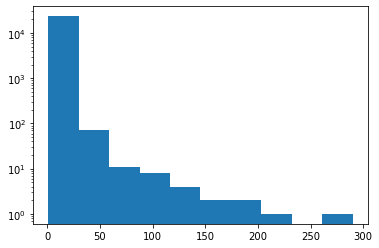

#####
#### GRAPH : gsrv_V4_cluster-1
#####

Number of clusters = 38801
Number of cluster with 1 seq = 34790
Number of cluster with > 3 seqs = 882

Length of the 0 component = 130

Sizes of the clusters:
{1, 130, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 44, 2, 57, 64, 65, 73, 75, 79, 81}


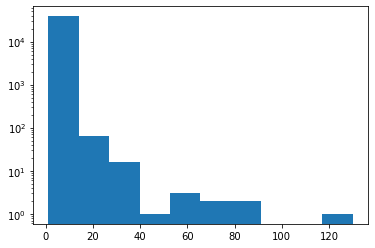

#############################
#### V_Region : V3-V4
#############################

#####
#### GRAPH : gsrv_V3-V4_cluster-0.99
#####

Number of clusters = 27003
Number of cluster with 1 seq = 20193
Number of cluster with > 3 seqs = 2528

Length of the 0 component = 436

Sizes of the clusters:
{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 54, 57, 59, 62, 63, 64, 66, 67, 68, 71, 85, 86, 94, 97, 107, 108, 110, 126, 141, 145, 179, 186, 211, 326, 373, 436}


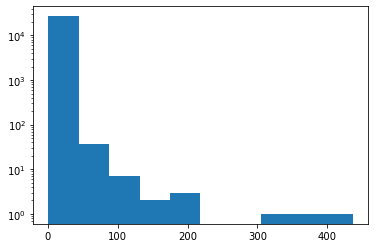

#####
#### GRAPH : gsrv_V3-V4_cluster-1
#####

Number of clusters = 50016
Number of cluster with 1 seq = 46337
Number of cluster with > 3 seqs = 466

Length of the 0 component = 110

Sizes of the clusters:
{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 26, 30, 32, 33, 43, 55, 71, 75, 110}


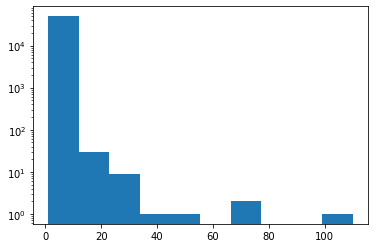

#############################
#### V_Region : V1-V3
#############################

#####
#### GRAPH : gsrv_V1-V3_cluster-0.99
#####

Number of clusters = 14664
Number of cluster with 1 seq = 10922
Number of cluster with > 3 seqs = 1235

Length of the 0 component = 262

Sizes of the clusters:
{1, 2, 3, 4, 5, 262, 7, 8, 9, 10, 11, 140, 13, 14, 15, 144, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 156, 29, 30, 31, 32, 33, 34, 35, 28, 37, 6, 39, 41, 42, 43, 45, 174, 46, 48, 49, 56, 57, 12, 62, 66, 72, 75, 77, 80, 16, 83, 103, 105, 118, 121}


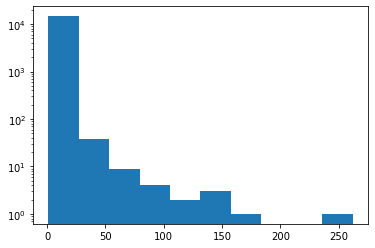

#####
#### GRAPH : gsrv_V1-V3_cluster-1
#####

Number of clusters = 26874
Number of cluster with 1 seq = 25566
Number of cluster with > 3 seqs = 80

Length of the 0 component = 15

Sizes of the clusters:
{1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 15}


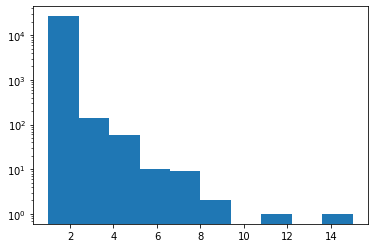

#############################
#### V_Region : V3-V5
#############################

#####
#### GRAPH : gsrv_V3-V5_cluster-0.99
#####

Number of clusters = 30710
Number of cluster with 1 seq = 23281
Number of cluster with > 3 seqs = 2760

Length of the 0 component = 322

Sizes of the clusters:
{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 67, 68, 69, 77, 82, 84, 85, 87, 93, 105, 106, 110, 117, 125, 139, 145, 148, 157, 158, 164, 217, 246, 262, 322}


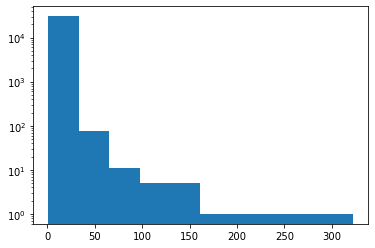

#####
#### GRAPH : gsrv_V3-V5_cluster-1
#####

Number of clusters = 56606
Number of cluster with 1 seq = 53011
Number of cluster with > 3 seqs = 380

Length of the 0 component = 97

Sizes of the clusters:
{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 22, 24, 25, 26, 30, 31, 32, 34, 40, 51, 64, 97}


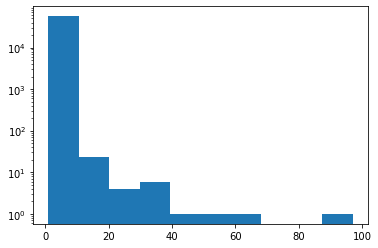

In [21]:
for v_region in v_regions:
    print(f"#############################\n#### V_Region : {v_region}\n#############################\n")
    for db, g in graphs[v_region].items():
        print(f"#####\n#### GRAPH : {db}\n#####\n")
        parse_cdhit.get_graph_information(g)

Above we can see that the cluster with 100% of identity have more clusters but with lower size, because it more difficult to group sequences in the same cluster.

### download results

In [22]:
%%time
taxon = ["family", "genus", "species"]
threads = 20
force = True

for v_region in v_regions:
    clusters_df_obj = join(
        f"Clustering/{v_region}", "clusters_df.pickle")

    if not exists(clusters_df_obj) or force:
        clusters_df = {}
        
        for key, g in graphs[v_region].items():
            df = parse_cdhit.results_to_df2(
                g, taxon, key, f"Clustering/{v_region}", 
                force=force, threads=threads)
            
            clusters_df[key] = df

        pickle.dump(clusters_df, open(clusters_df_obj, 'wb'))

CPU times: user 2min 42s, sys: 14.6 s, total: 2min 57s
Wall time: 3min 5s


## Get clusterized sequences and taxa

Centroid = first member of the cluster

If the cluster len = 1:
- Put the sequence and taxa of this centroid  

else:
- Put the sequence of the centroid (first element)
- Join the taxonomies

In [23]:
%%time
%autoreload
db_clu = {}
threads=25
force = True


for v_region in v_regions:
    db_clu[v_region] = {}
    db_clu_obj = join(
        f"Clustering/{v_region}", f"db_clu_dict_{v_region}.pickle")

    if not exists(db_clu_obj) or force:
        for db, g in graphs[v_region].items():
            ## In cluster with 100% identity keep only the centroid
            if '1' in db:
                only_centroid = True
            else:
                only_centroid = False

            args = [(g.subgraph(comp), only_centroid) for comp in list(nx.connected_components(g))]

            with mp.Pool(processes=threads) as pool:
                try:
                    results = pool.starmap(
                        parse_cdhit.get_taxa_from_cluster, args)
                except Exception as e:
                    pool.terminate()
                    raise e

            if only_centroid:
                db_clu[v_region][db] = {
                    item[0]:item[1] for item in results}
            else:
                db_clu[v_region][db] = {
                    i:tax.copy() for ids, tax in results for i in ids}

        pickle.dump(db_clu, open(db_clu_obj, 'wb'))
    else:
        db_clu = pickle.load(open(db_clu_obj, 'rb'))

CPU times: user 1min 38s, sys: 19.7 s, total: 1min 58s
Wall time: 2min 12s


At this point, we have decided to only work with clusters at 100% identity, because for V4 region we think that is a better approach.  

Add sequences and check if all the centroids from the fasta file are recorded.

In [24]:
# Append seqs
for v_region in v_regions:
    print(f"### {v_region}")
    for key, db in db_clu[v_region].items():
        # Choose cluster fasta
        if '1' in key:
            fasta_file = join(f"Clustering/{v_region}", key)
        # Choose original fasta
        else:
            fasta_file = env_files[v_region]['seq']

        print(f"{fasta_file} --> {key}")

        with open(fasta_file, "r") as seqsfile:
            for record in SeqIO.parse(seqsfile, "fasta"):
                ID = record.id
                seq= record.seq

                if ID in db:
                    db[ID]['seq'] = seq
                else:
                    print(f"{ID} not in {key} db")

### V4
created_db/gsrv_V4_seqs.fasta --> gsrv_V4_cluster-0.99
Clustering/V4/gsrv_V4_cluster-1 --> gsrv_V4_cluster-1
### V3-V4
created_db/gsrv_V3-V4_seqs.fasta --> gsrv_V3-V4_cluster-0.99
Clustering/V3-V4/gsrv_V3-V4_cluster-1 --> gsrv_V3-V4_cluster-1
### V1-V3
Clustering/V1-V3/gsrv_V1-V3_cluster-0.99 --> gsrv_V1-V3_cluster-0.99
Clustering/V1-V3/gsrv_V1-V3_cluster-1 --> gsrv_V1-V3_cluster-1
### V3-V5
created_db/gsrv_V3-V5_seqs.fasta --> gsrv_V3-V5_cluster-0.99
Clustering/V3-V5/gsrv_V3-V5_cluster-1 --> gsrv_V3-V5_cluster-1


Downloand clusters files

In [25]:
force = True
for v_region in v_regions:
    for key, db in db_clu[v_region].items():
        print(key)
        # Download as txt and fasta
        taxa_file = join(db_dir, f"{key}_taxa.txt")
        seqs_file = join(db_dir, f"{key}_seqs.fasta")
        

        if not exists(taxa_file) or not exists(seqs_file) or force:
            utils.download_db_from_dict(db, 
                                        taxa_out_file = taxa_file,
                                        seqs_out_file = seqs_file)
            utils.file_to_qza(taxa_file, input_type = 'taxa')
            utils.file_to_qza(seqs_file, input_type = 'seq')

gsrv_V4_cluster-0.99
gsrv_V4_cluster-1
gsrv_V3-V4_cluster-0.99
gsrv_V3-V4_cluster-1
gsrv_V1-V3_cluster-0.99
gsrv_V1-V3_cluster-1
gsrv_V3-V5_cluster-0.99
gsrv_V3-V5_cluster-1
